In [1]:
# To run this in Google Colab, uncomment the following line
# !pip install "git+https://github.com/GPflow/GeometricKernels.git"

# If you want to use a version of the library from a different git branch,
# say, from the "devel" branch, uncomment the line below instead
# !pip install "git+https://github.com/GPflow/GeometricKernels@devel#egg=GeometricKernels"

# Matérn and Heat Kernels on Spheres

This notebook shows how define and evaluate kernels on the two-dimensional sphere $\mathbb{S}_2 \subseteq \mathbb{R^3}$.

Handling hyperspheres $\mathbb{S}_d \subseteq \mathbb{R}^{d+1}$ for $d \geq 2$ is the same.
We chose to showcase $\mathbb{S}_2$ here because (1) it is probably the most well known case (2) it is easy to visualize.

**Note:** the points on the (hyper)sphere $\mathbb{S}_d$ are represented by vectors (`array`s of the suitable backend) in $\mathbb{R}^{d+1}$ whose Euclidean norm is equal to $1$.

We use the **numpy** backend here.

In [2]:
# Import a backend, we use numpy in this example.
import numpy as np

# Import the geometric_kernels backend.
import geometric_kernels

# Note: if you are using a backend other than numpy,
# you _must_ uncomment one of the following lines
# import geometric_kernels.tensorflow
# import geometric_kernels.torch
# import geometric_kernels.jax

# Import a space and an appropriate kernel.
from geometric_kernels.spaces import Hypersphere
from geometric_kernels.kernels import MaternGeometricKernel

import matplotlib as mpl
import matplotlib.pyplot as plt

INFO: Using numpy backend


## Defining a Space

First we create a GeometricKernels `space` that corresponds to the 2-dimensional sphere $\mathbb{S}_2$, a subset of $\mathbb{R}^3$.

In [3]:
sphere = Hypersphere(dim=2)

## Defining a Kernel

First, we create a generic Matérn kernel.

To initialize `MaternGeometricKernel` you just need to provide a `Space` object, in our case this is the `sphere` we have just created above.

There is also an optional second parameter `num` which determines the order of approximation of the kernel.
There is a sensible default value for each of the spaces in the library, so change it only if you know what you are doing.

A brief account on theory behind the kernels on compact manifold like (which hyperspheres are examples of) can be found on these documentation pages: [one](https://gpflow.github.io/GeometricKernels/theory/compact.html), [two](https://gpflow.github.io/GeometricKernels/theory/addition_theorem.html).

In [4]:
kernel = MaternGeometricKernel(sphere)

To support JAX, our classes do not keep variables you might want to differentiate over in their state.
Instead, some methods take a `params` dictionary as input, returning its modified version.

The next line initializes the dictionary of kernel parameters `params` with some default values.

**Note:** our kernels do not contain the outputscale/variance parameter frequently used in Gaussian processes.
However, it is usually trivial to add it by multiplying the kernel by an (optimizable) constant.

In [5]:
params = kernel.init_params()
print('params:', params)

params: {'lengthscale': array(1.), 'nu': array(inf)}


To define two different kernels, Matern-3/2 and Matern-∞ (aka heat, RBF, squared exponential, diffusion), we need two different versions of `params`:

In [6]:
params["lengthscale"] = np.array([0.125])
params_32  = params.copy()
params_inf = params.copy()
del params
params_32["nu"]  = np.array([3/2])
params_inf["nu"] = np.array([np.inf])

Now two kernels are *defined* and we proceed to evaluating both on a set of random inputs.

## Evaluating Kernels on Random Inputs

We start by sampling `10` (uniformly) random points on the sphere $\mathbb{S}_2$.
An explicit `key` parameter is needed to support JAX as one of the backends.

In [7]:
key = np.random.RandomState(1234)

key, xs = sphere.random(key, 10)

print(xs)

[[ 0.2453089  -0.61971816  0.74550181]
 [-0.26385701 -0.60812805  0.74870539]
 [ 0.80356397 -0.59503751  0.01467335]
 [-0.8280059   0.42459658  0.3662294 ]
 [ 0.42189482 -0.89450892 -0.14784637]
 [ 0.00425403  0.81421747  0.58054441]
 [ 0.64624279 -0.75666681 -0.09912418]
 [-0.74561122  0.21985349  0.62906943]
 [ 0.84836694 -0.30204652  0.43478896]
 [-0.86072199 -0.08673813  0.50163149]]


Now we evaluate the two kernel matrices.

In [8]:
kernel_mat_32  = kernel.K(params_32,  xs, xs)
kernel_mat_inf = kernel.K(params_inf, xs, xs)

Finally, we visualize these matrices using `imshow`.

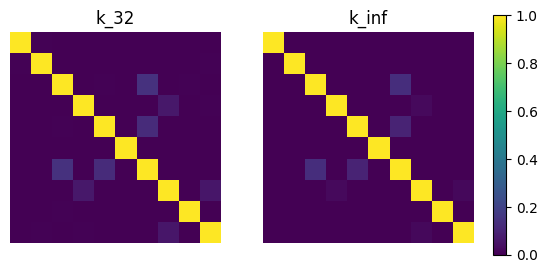

In [9]:
# find common range of values
minmin = np.min([np.min(kernel_mat_32), np.min(kernel_mat_inf)])
maxmax = np.max([np.max(kernel_mat_32), np.max(kernel_mat_inf)])

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
cmap = plt.get_cmap('viridis')

ax1.imshow(kernel_mat_32, vmin=minmin, vmax=maxmax, cmap=cmap)
ax1.set_title('k_32')
ax1.set_axis_off()

ax2.imshow(kernel_mat_inf, vmin=minmin, vmax=maxmax, cmap=cmap)
ax2.set_title('k_inf')
ax2.set_axis_off()

# add space for color bar
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])

# add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin, vmax=maxmax))
fig.colorbar(sm, cax=cbar_ax)

plt.show()

## Visualize Kernels

The sphere $\mathbb{S}_2$ is one of the few manifolds we can easily visualize.
Because of this, beyond kernel matrices, we will plot the functions $k_{\nu, \kappa}(\text{pole}, \cdot)$.

In practice, we visualize $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points`.
The `base_point` is simply the north pole.
The `other_points` is defined by the `_NUM_LATS` x `_NUM_LONGS` uniform grid.

We define `base_point` and `other_points` in the next cell.

In [10]:
base_point = np.array([[0.0, 0.0, 1.0]])

# define latitude and longitude discretization
_NUM_LATS = 128
_NUM_LONGS = 128

# generate a grid on the sphere
lats, longs =  np.mgrid[0:2*np.pi:_NUM_LATS*1j, 0:np.pi:_NUM_LONGS*1j]

other_points_xs = np.sin(longs) * np.cos(lats)
other_points_ys = np.sin(longs) * np.sin(lats)
other_points_zs = np.cos(longs)

other_points = np.c_[np.ravel(other_points_xs),
                     np.ravel(other_points_ys),
                     np.ravel(other_points_zs)]

The next cell evaluates $k_{\nu, \kappa}($ `base_point` $, x)$ for $x \in $ `other_points` for $\nu$ either $3/2$ or $\infty$.

In [11]:
kernel_vals_32  = kernel.K(params_32,  base_point, other_points)
kernel_vals_inf = kernel.K(params_inf, base_point, other_points)

Finally, we are ready to plot the results.

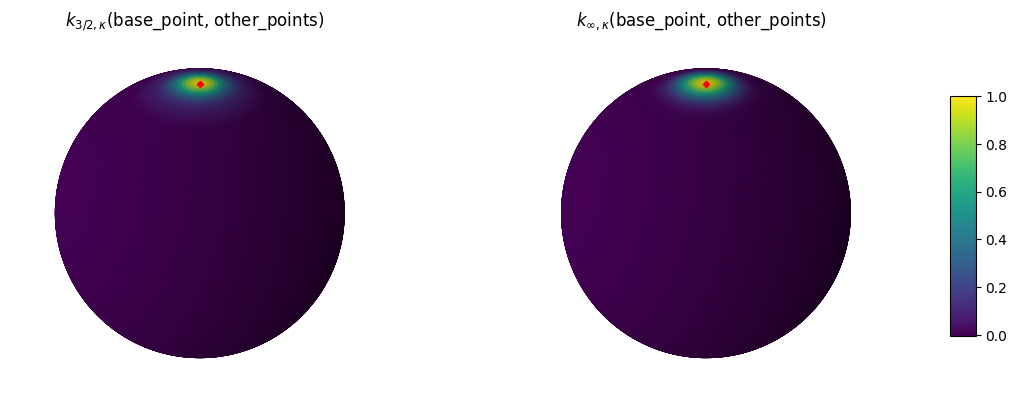

In [12]:
fig, (ax1, ax2) = plt.subplots(figsize=(12.8, 4.8), nrows=1, ncols=2,
                               subplot_kw=dict(projection='3d',
                                               computed_zorder=False))

cmap = plt.get_cmap('viridis')

surf1 = ax1.plot_surface(other_points_xs, other_points_ys, other_points_zs,
                         facecolors=cmap(kernel_vals_32[0, :].reshape(_NUM_LATS, _NUM_LONGS)),  cstride=1, rstride=1)
surf2 = ax2.plot_surface(other_points_xs, other_points_ys, other_points_zs,
                         facecolors=cmap(kernel_vals_inf[0, :].reshape(_NUM_LATS, _NUM_LONGS)), cstride=1, rstride=1)

# Remove axis
ax1._axis3don = False
ax2._axis3don = False

# Set aspect ratio
ax1.set_box_aspect((np.ptp(other_points_xs), np.ptp(other_points_ys),
                    np.ptp(other_points_zs)), zoom=1.5)
ax2.set_box_aspect((np.ptp(other_points_xs), np.ptp(other_points_ys),
                    np.ptp(other_points_zs)), zoom=1.5)

# plot the base point
ax1.scatter(base_point[0, 0], base_point[0, 1], base_point[0, 2], s=10, c='r', marker='D')
ax2.scatter(base_point[0, 0], base_point[0, 1], base_point[0, 2], s=10, c='r', marker='D')

# find common range of values
minmin_vis = np.min([np.min(kernel_vals_32), np.min(kernel_vals_inf)])
maxmax_vis = np.max([np.max(kernel_vals_32), np.max(kernel_vals_inf)])

ax1.set_title(r'$k_{3/2, \kappa}($base_point, other_points$)$')
ax2.set_title('$k_{\infty, \kappa}($base_point, other_points$)$')

# add color bar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin_vis, vmax=maxmax_vis))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])
fig.colorbar(sm, cax=cbar_ax)

plt.show()

# Feature Maps and Sampling

Here we show how to get an approximate finite-dimensional feature map for heat and Matérn kernels on the sphere, i.e. such $\phi$ that
$$
k(x, x') \approx \langle \phi(x), \phi(x') \rangle_{\mathbb{R}^M}.
$$
This might be useful for speeding up computations.
We showcase this below by showing how to efficiently sample the Gaussian process $\mathrm{GP}(0, k)$.

For a brief theoretical introduction into feature maps, see this [documentation page](https://gpflow.github.io/GeometricKernels/theory/feature_maps.html).

The simplest way to get an approximate finite-dimensional feature map is to use the `default_feature_map` function from `geometric_kernels.kernels`.
It has an optional keyword argument `num` which determines the number of features, the $M$ above.
Below we rely on the default value of `num`.

In [13]:
from geometric_kernels.kernels import default_feature_map

feature_map = default_feature_map(sphere, kernel=kernel)

The resulting `feature_map` is a function that takes the array of inputs and parameters of the kernel.
There is also an optional parameter `normalize` that determines if $\langle \phi(x), \phi(x) \rangle_{\mathbb{R}^M} \approx 1$ or not.
For the (hyper)sphere, `normalize` follows the standard behavior of `MaternKarhunenLoeveKernel`, being `True` by default.

`feature_map` outputs a tuple.
Its first element is $\phi(x)$ evaluated at all inputs $x$.
Its second element is the context dict.
The latter is either empty (as in our case) or contains the updated random key for randomized feature maps.
For `default_feature_map` on a `Hypersphere` space the context is empty.

In the next cell, we evaluate the feature map at random points, using `params_32` as kernel parameters.
We check the basic property of the feature map: $k(x, x') \approx \langle \phi(x), \phi(x') \rangle_{\mathbb{R}^M}$.

In [14]:
# xs are random points from above
embedding, _ = feature_map(xs, params_32)

print('xs (shape = %s):\n%s' % (xs.shape, xs))
print('')
print('emedding (shape = %s):\n%s' % (embedding.shape, embedding))

kernel_mat_32  = kernel.K(params_32,  xs, xs)
kernel_mat_32_alt = np.matmul(embedding, embedding.T)

print('')
print('||k(xs, xs) - phi(xs) * phi(xs)^T|| =', np.linalg.norm(kernel_mat_32 - kernel_mat_32_alt))

xs (shape = (10, 3)):
[[ 0.2453089  -0.61971816  0.74550181]
 [-0.26385701 -0.60812805  0.74870539]
 [ 0.80356397 -0.59503751  0.01467335]
 [-0.8280059   0.42459658  0.3662294 ]
 [ 0.42189482 -0.89450892 -0.14784637]
 [ 0.00425403  0.81421747  0.58054441]
 [ 0.64624279 -0.75666681 -0.09912418]
 [-0.74561122  0.21985349  0.62906943]
 [ 0.84836694 -0.30204652  0.43478896]
 [-0.86072199 -0.08673813  0.50163149]]

emedding (shape = (10, 625)):
[[ 0.09376086  0.11951028  0.08744111 ... -0.00157185  0.00251296
  -0.00400984]
 [ 0.09376086  0.12002385  0.01822028 ... -0.00638262 -0.00453832
  -0.00676826]
 [ 0.09376086  0.00235226  0.16004253 ...  0.00755932 -0.02117796
  -0.01170088]
 ...
 [ 0.09376086  0.10084518 -0.11923475 ...  0.00760901  0.0055675
   0.00056405]
 [ 0.09376086  0.06970037  0.14023769 ...  0.00683025 -0.00032952
   0.00708224]
 [ 0.09376086  0.0804158  -0.10764934 ...  0.00091644 -0.0114463
  -0.00911484]]

||k(xs, xs) - phi(xs) * phi(xs)^T|| = 7.135852551570499e-08


## Efficient Sampling using Feature Maps

GeometricKernels provides a simple tool to efficiently sample (without incurring cubic costs) the Gaussian process $f \sim \mathrm{GP}(0, k)$, based on an approximate finite-dimensional feature map $\phi$.
The underlying machinery is briefly discussed in this [documentation page](https://gpflow.github.io/GeometricKernels/theory/feature_maps.html).

The function `sampler` from `geometric_kernels.sampling` takes in a feature map and, optionally, the keyword argument `s` that specifies the number of samples to generate.
It returns a function we name `sample_paths`.

`sample_paths` operates much like `feature_map` above: it takes in the points where to evaluate the samples and kernel parameters.
Additionally, it takes in the keyword argument `key` that specifies randomness in the JAX style.
`sample_paths` returns a tuple.
Its first element is the updated `key`.
Its second element is an array containing the value of samples evaluated at the input points.

In [15]:
from geometric_kernels.sampling import sampler

sample_paths = sampler(feature_map, s=2)

# introduce random state for reproducibility (optional)
# `key` is jax's terminology
key = np.random.RandomState(seed=1234)

# new random state is returned along with the samples
key, samples = sample_paths(xs, params_32, key=key)

print('Two samples evaluated at the xs are:')
print(samples)

Two samples evaluated at the xs are:
[[-1.29069585 -0.01041101]
 [ 2.01336839 -1.95191793]
 [-1.49327738  1.92384669]
 [ 1.31761053 -0.22536113]
 [-1.49768197  1.1820927 ]
 [ 0.78375705  0.66272096]
 [ 0.80986624  0.71381255]
 [-0.61199106  1.25119496]
 [-0.91047904  0.08939757]
 [-0.62337665 -1.07361393]]


### Visualizing Samples
Here we visualize samples as functions on the sphere.

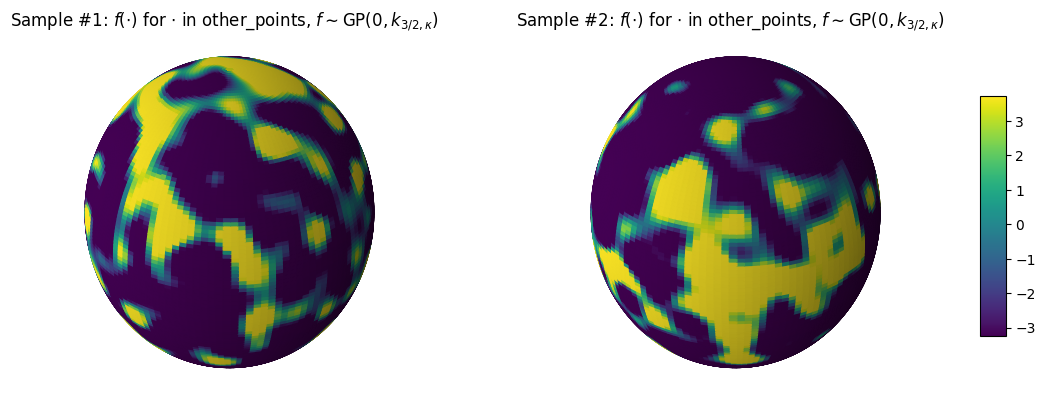

In [16]:
key = np.random.RandomState(seed=1234)
key, samples = sample_paths(other_points, params_32, key=key)

sample1 = samples[:, 0]
sample2 = samples[:, 1]

fig, (ax1, ax2) = plt.subplots(figsize=(12.8, 4.8), nrows=1, ncols=2,
                               subplot_kw=dict(projection='3d',
                                               computed_zorder=False))

cmap = plt.get_cmap('viridis')

surf1 = ax1.plot_surface(other_points_xs, other_points_ys, other_points_zs,
                         facecolors=cmap(sample1.reshape(_NUM_LATS, _NUM_LONGS)),  cstride=1, rstride=1)
surf2 = ax2.plot_surface(other_points_xs, other_points_ys, other_points_zs,
                         facecolors=cmap(sample2.reshape(_NUM_LATS, _NUM_LONGS)), cstride=1, rstride=1)

# Remove axis
ax1._axis3don = False
ax2._axis3don = False

# Set aspect ratio
ax1.set_box_aspect((np.ptp(other_points_xs), np.ptp(other_points_ys),
                    np.ptp(other_points_zs)), zoom=1.5)
ax2.set_box_aspect((np.ptp(other_points_xs), np.ptp(other_points_ys),
                    np.ptp(other_points_zs)), zoom=1.5)

# find common range of values
minmin_vis = np.min([np.min(sample1), np.min(sample2)])
maxmax_vis = np.max([np.max(sample1), np.max(sample2)])

ax1.set_title('Sample #1: $f(\cdot)$ for $\cdot$ in other_points, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$')
ax2.set_title('Sample #2: $f(\cdot)$ for $\cdot$ in other_points, $f \sim \mathrm{GP}(0, k_{3/2, \kappa})$')

# add color bar
sm = plt.cm.ScalarMappable(cmap=cmap,
                           norm=plt.Normalize(vmin=minmin_vis, vmax=maxmax_vis))
fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])
fig.colorbar(sm, cax=cbar_ax)

plt.show()

# Citation

If you are using (hyper)spheres and GeometricKernels, please consider citing

```
@article{borovitskiy2020,
    title={Matern Gaussian processes on Riemannian manifolds},
    author={Viacheslav Borovitskiy and Alexander Terenin and Peter Mostowsky and Marc Peter Deisenroth},
    booktitle={Advances in Neural Information Processing Systems},
    year={2020}}
```